# Euclidean Distances
This notebook compares the distances traveled in cities by their euclidean variant, the route as the crow flies. Some cities have more detour than others, this can be a very important indicator of urban form.

# Imports, Methods & Data
These are automatically executed using the initialisation-cells plugin.

In [5]:
import json
import requests
import matplotlib.pyplot as plt
from shapely.geometry import Point
import os
import os.path
import glob
import numpy as np
import pandas as pd
import geopandas as gpd
from math import ceil
from pyproj import CRS

import seaborn as sns
sns.set()

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline

DROOT = './data'

In [6]:
def weighted_mean(df, weight='cell_pop'):
    """Returns the weighted mean of a dataframe."""
    return df.apply(lambda x: (x * df[weight]).sum() / df[weight].sum())
    
df = pd.DataFrame({
    "A": [10, 20, 30], 
    "B": [20, 30, 40], 
    "C": [ 1,  2,  3],  })

assert weighted_mean(df, weight='C').B    == (100 / 3)   # 33.333..
assert weighted_mean(df, weight='C').A == (10 / 3 + 20)  # 23.333..

In [7]:
def utm_epsg_from_latlot(lat, lon):
    zone = utm.from_latlon(lat, lon)[2]
    return f"326{zone:02d}" if lat >= 0 else f"327{zone:02d}"

def utm_epsg_from_point(point):
    return utm_epsg_from_latlot(point.y, point.x)

In [53]:
# Load Cities transport times.
gdf_original = gpd.read_file(
    os.path.join(DROOT, '4-processed', 'complete-dataset.gpkg'))
gdf_original = gdf_original.to_crs(epsg=4326)
gdf_total = gdf_original.copy() 

# Procedures

## Generate route distance average per ring

In [54]:
# Groupby city and then created bins. 
selection = gdf_total.groupby(['city', 'sky_d_bin'])
columns = ['sky_d',
           'car_r_d', 'car_r_t', 'car_m_d', 'car_m_t', 
           'pt_r_d', 'pt_r_t', 'pt_m_d', 'pt_m_t', 
           'bike_d', 'bike_t', 'walk_d', 'walk_t', 'cell_pop']

# Generate GeoDataFrame to add columns to.
print("Merging ring geometries..")
gdf_rings = gpd.GeoDataFrame(
    crs=gdf_total.crs,
    geometry=selection.progress_apply(lambda x: x.unary_union))

# Total ring population.
gdf_rings['ring_pop'] = selection.cell_pop.sum() 

# Amount of cells considered.
gdf_rings['n'] = selection.size()

# Weighted means for all existing columns, then drop mandatory cell_pop.
print("Weighing means..")
gdf_rings[columns] = selection[columns].progress_apply(weighted_mean)
gdf_rings.drop(columns=['cell_pop'])

# Generate eucledian deviates from averages.
for col in ['car_r_d', 'car_m_d', 'pt_r_d', 'pt_m_d', 'bike_d', 'walk_d']:
    gdf_rings[col + 'eu'] = gdf_rings[col] - gdf_rings.sky_d

gdf_rings.head(2)

Merging ring geometries..



Weighing means..


/Users/ivo/opt/anaconda3/envs/thesis-env/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


geometry  \
city   sky_d_bin                                                      
Aarhus 0.0        POLYGON ((16.19456 56.14787, 16.19096 56.14787...   
       0.5        POLYGON ((16.21213 56.14536, 16.21170 56.14284...   

                      ring_pop   n     sky_d   car_r_d     car_r_t   car_m_d  \
city   sky_d_bin                                                               
Aarhus 0.0         9147.316925  19  0.263077  1.421835  256.729202  1.421835   
       0.5        20122.554169  48  0.747927  1.639041  298.600969  1.639041   

                     car_m_t    pt_r_d      pt_r_t  ...      bike_t    walk_d  \
city   sky_d_bin                                    ...                         
Aarhus 0.0        262.773087  0.522601  376.087971  ...  182.178263  0.821942   
       0.5        304.452356  1.268180  741.691067  ...  312.850853  1.187158   

                      walk_t    cell_pop  car_r_deu  car_m_deu  pt_r_deu  \
city   sky_d_bin                                                           
Aarhus 0.0        591.565078  515.670536   1.158759   1.158759  0.259524   
       0.5        854.646164  496.959362   0.891114   0.891114  0.520253   

                  pt_m_deu  bike_deu  walk_deu  
city   sky_d_bin                                
Aarhus 0.0        0.258624  0.439794  0.558865  
       0.5        0.549133  0.607648  0.439231  

[2 rows x 23 columns]

## City mode detour (route_d minus euclidean_d) made per mode

**above-euclidean-distance.csv**

Describes how large a detour a mode route makes on average compared to its euclidean point-to-point=shortest distance. These results are weighted by population. 

* city: main cityname key, index
* car_r_deu: distance a car in rush-hour makes on average over the euclidean distance. 
* car_m_deu: car at midday
* bike_deu: bike
* walk_deu: walking
* pt_r_deu: public transit in rush-hour
* pt_m_deu: public transit at midday
* n_consid: amount of routes considered in this weighing. 

In [19]:
# Generate data on the amount of detour 
columns = ['car_r_deu', 'car_m_deu', 'bike_deu', 'walk_deu', 'pt_r_deu', 'pt_m_deu']
gdf_detour = gdf_rings[columns].groupby('city').mean().copy()
gdf_detour['n_consid'] = gdf_rings.groupby('city').n.sum()
gdf_detour = gdf_detour[gdf_detour.n_consid >= 1500]

gdf_detour.to_csv(os.path.join(DROOT, '4-processed', 'above-eucl-distance.csv'))
gdf_detour.head(5)

car_r_deu  car_m_deu  bike_deu  walk_deu  pt_r_deu  pt_m_deu  \
city                                                                      
Adelaide    1.558828   1.558828  1.353644  0.943405  1.870912  1.972885   
Amsterdam   4.280744   4.280744  1.661120  1.221811  3.513458  3.430043   
Auckland    3.098294   3.098294  2.064074  1.318402  2.141197  2.377752   
Barcelona   3.140162   3.140162  1.492571  0.954025  2.208762  2.187485   
Berlin      1.945317   1.945317  1.671307  0.920528  2.170509  2.139093   

           n_consid  
city                 
Adelaide       4183  
Amsterdam      3760  
Auckland       2611  
Barcelona      2539  
Berlin         5186

In [24]:
# Detour over euclidean distance
os.makedirs(os.path.join(DROOT, '4-processed', 'euclidean-detour'), exist_ok=True)
for col in ['car_r_deu', 'car_m_deu', 'pt_r_deu', 
            'pt_m_deu', 'bike_deu', 'walk_deu']:
    df_detour = gdf_rings[col].unstack(-1)
    df_detour.to_csv(
        os.path.join(DROOT, '4-processed', 'euclidean-detour', f'ed-{col}.csv'),
        float_format="%.2f")
    df_detour.to_json(
        os.path.join(DROOT, '4-processed', 'euclidean-detour', f'ed-{col}.json'),
        double_precision=2)

## Finding the average speed per distance

In [25]:
# Create new copy of gdf_rings, called ring speeds (rspeeds)
gdf_rspeeds = pd.DataFrame()

gdf_rspeeds['walk_s'] = gdf_rings.walk_d / (gdf_rings.walk_t / 3600)
gdf_rspeeds['bike_s'] = gdf_rings.bike_d / (gdf_rings.bike_t / 3600)
gdf_rspeeds['car_r_s'] = gdf_rings.car_r_d / (gdf_rings.car_r_t / 3600)
gdf_rspeeds['car_m_s'] = gdf_rings.car_m_d / (gdf_rings.car_m_t / 3600)
gdf_rspeeds['pt_r_s'] = gdf_rings.pt_r_d / (gdf_rings.pt_r_t / 3600)
gdf_rspeeds['pt_m_s'] = gdf_rings.pt_m_d / (gdf_rings.pt_m_t / 3600)

# Write out average city speed per mode
os.makedirs(os.path.join(DROOT, '4-processed', 'euclidean-speed'), exist_ok=True)
for col in ['walk_s', 'bike_s', 'car_r_s', 'car_m_s', 'pt_r_s', 'pt_m_s']:
    df_detour = gdf_rspeeds[col].unstack(0)
    df_detour.to_csv(
        os.path.join(DROOT, '4-processed', 'euclidean-speed', col + '.csv'),
        float_format="%.2f"
    )
    df_detour.to_json(
        os.path.join(DROOT, '4-processed', 'euclidean-speed', col + '.json'),
        double_precision=2
    )

gdf_rspeeds

walk_s     bike_s    car_r_s    car_m_s     pt_r_s  \
city   sky_d_bin                                                         
Aarhus 0.0        5.001970  13.888805  19.937207  19.478678   5.002457   
       0.5        5.000630  15.598711  19.760233  19.380558   6.155141   
       1.0        5.000454  16.535685  21.047057  20.925638   8.512136   
       1.5        5.000799  16.667751  22.001930  21.876282   9.691973   
       2.0        5.000463  16.914664  23.006983  22.594108  10.698140   
...                    ...        ...        ...        ...        ...   
York   3.0        5.000232  16.733351  23.194889  23.334638  10.767407   
       3.5        5.000120  16.880938  24.689454  24.615606  11.143146   
       4.0        5.000284  16.886723  27.126007  25.774369  10.509006   
       4.5        4.999835  17.045775  27.875727  27.892676  10.160684   
       5.0        5.000350  17.046231  34.866239  34.133572  10.541296   

                     pt_m_s  
city   sky_d_bin             
Aarhus 0.0         5.047172  
       0.5         6.167366  
       1.0         8.927859  
       1.5         9.935815  
       2.0        11.150095  
...                     ...  
York   3.0        10.705224  
       3.5        11.145472  
       4.0        10.506944  
       4.5        10.207492  
       5.0        10.541296  

[1105 rows x 6 columns]

## Switching point car/bike in different cities
By finding the switching point where the car becomes faster than the bike we can tell something about the attractiveness for bikers there.

In [ ]:
# Get fastest mode in rush hour and midday per cell. 
modes_r = ['bike_t', 'car_r_t', 'pt_r_t', 'walk_t']
modes_m = ['bike_t', 'car_m_t', 'pt_m_t', 'walk_t']
gdf_padd['recmode_r'] = gdf_padd[modes_r].idxmin(1)
gdf_padd['recmode_m'] = gdf_padd[modes_m].idxmin(1)

# Rename column values so we don't mix them up next.
gdf_padd.recmode_r.replace({'bike_t': 'bike_r_t',
                             'walk_t': 'walk_r_t'}, inplace=True)
gdf_padd.recmode_m.replace({'bike_t': 'bike_m_t',
                             'walk_t': 'walk_r_t'}, inplace=True)

In [ ]:
# Generate graphs for every 30 seconds for 15 minutes
values = {}
for padding in tqdm(range(0, 930, 30)):

    stats_na = stats.dropna()
    
    # Create rush-hour dataframe.
    intersect_r = {
        cityname: intersect(
            stats_na.loc[cityname].bike_t,
            stats_na.loc[cityname].car_r_t + padding,
        )
        for cityname, city in stats_na.groupby('city')
    }
    
    bike_car_r = pd.DataFrame.from_dict(intersect_r, orient='index')
    bike_car_r = bike_car_r.rename(columns={'idx': 'car_r_d'})

    # Create mid-day dataframe.
    intersect_m = {
        name: intersect(
            stats_na.loc[name].bike_t,
            stats_na.loc[name].car_m_t + padding,
        )
        for name, city in stats_na.groupby('city')
    }
    
    bike_car_m = pd.DataFrame.from_dict(intersect_m, orient='index')
    bike_car_m = bike_car_m.rename(columns={'idx': 'car_m_d'})

    # Combine the two dataframes based on their common key (city).
    its_df = bike_car_r.join(bike_car_m, lsuffix='_r', rsuffix='_m')
    its_df = its_df.sort_values('car_r_d', ascending=False)
    its_df = its_df.dropna()
    
    values[padding] = its_df[['car_r_d', 'car_m_d']].unstack(-1)
    
total_values = pd.DataFrame(values)
total_values.index = total_values.index.set_names(['car_deptime', 'city'])

outpath = os.path.join(DROOT, '4-processed', 'townhall_car-vs-bike.csv')
total_values.to_csv(outpath)
total_values.loc['car_r_d'].sort_values(by=300, ascending=False).head(7)

# Visualisations

## Example Rings
Show how the rings create averages

In [41]:
gdf_rings

geometry  \
city   sky_d_bin                                                      
Aarhus 0.0        POLYGON ((1802769.998 7587909.098, 1802369.415...   
       0.5        POLYGON ((1802675.654 7586903.586, 1802275.104...   
       1.0        POLYGON ((1802581.341 7585898.253, 1802180.824...   
       1.5        MULTIPOLYGON (((1802887.542 7584893.099, 18024...   
       2.0        MULTIPOLYGON (((1801638.995 7584390.590, 18012...   
...                                                             ...   
York   3.0        MULTIPOLYGON (((1879207.901 7157652.821, 18788...   
       3.5        MULTIPOLYGON (((1878047.563 7157652.821, 18776...   
       4.0        MULTIPOLYGON (((1877274.004 7157652.821, 18768...   
       4.5        MULTIPOLYGON (((1878713.375 7168386.138, 18787...   
       5.0        POLYGON ((1886829.579 7169787.608, 1886442.423...   

                      ring_pop   n     sky_d   car_r_d     car_r_t   car_m_d  \
city   sky_d_bin                                                               
Aarhus 0.0         9147.316925  19  0.263077  1.421835  256.729202  1.421835   
       0.5        20122.554169  48  0.747927  1.639041  298.600969  1.639041   
       1.0        21461.991859  70  1.275927  2.310003  395.111940  2.310003   
       1.5        19583.590332  79  1.764273  2.865169  468.393961  2.865169   
       2.0        16970.767180  84  2.232300  3.434542  539.114977  3.434542   
...                        ...  ..       ...       ...         ...       ...   
York   3.0        18045.732950  84  3.256798  4.628141  721.370862  4.628141   
       3.5        12562.346703  65  3.726213  5.337116  778.506479  5.337116   
       4.0         3491.723393  29  4.155061  5.850223  776.330056  5.850223   
       4.5          873.525786  12  4.756600  7.416168  957.679947  7.416168   
       5.0          596.726448   7  5.135123  8.718403  900.137261  8.718403   

                     car_m_t    pt_r_d       pt_r_t  ...       bike_t  \
city   sky_d_bin                                     ...                
Aarhus 0.0        262.773087  0.522601   376.087971  ...   182.178263   
       0.5        304.452356  1.268180   741.691067  ...   312.850853   
       1.0        397.404900  2.202713   931.590129  ...   443.290883   
       1.5        471.316952  2.922299  1087.872715  ...   558.256400   
       2.0        548.332908  3.673174  1235.084247  ...   655.030482   
...                      ...       ...          ...  ...          ...   
York   3.0        716.991404  5.010464  1675.086710  ...   959.638317   
       3.5        780.869799  5.755627  1859.370031  ...  1107.779342   
       4.0        817.037841  6.075941  2081.388102  ...  1232.070087   
       4.5        957.049047  5.843422  2070.552585  ...  1246.313335   
       5.0        919.464563  6.150724  2100.702843  ...  1355.007314   

                    walk_d       walk_t    cell_pop  car_r_deu  car_m_deu  \
city   sky_d_bin                                                            
Aarhus 0.0        0.821942   591.565078  515.670536   1.158759   1.158759   
       0.5        1.187158   854.646164  496.959362   0.891114   0.891114   
       1.0        1.774594  1277.592008  384.035886   1.034077   1.034077   
       1.5        2.324266  1673.186186  319.066132   1.100896   1.100896   
       2.0        2.870840  2066.832718  262.727926   1.202242   1.202242   
...                    ...          ...         ...        ...        ...   
York   3.0        4.224551  3041.535916  337.085424   1.371343   1.371343   
       3.5        4.793463  3451.211179  318.347663   1.610903   1.610903   
       4.0        5.367098  3864.091594  266.376060   1.695162   1.695162   
       4.5        5.717081  4116.434882  324.170089   2.659567   2.659567   
       5.0        6.270819  4514.673322  228.546131   3.583280   3.583280   

                  pt_r_deu  pt_m_deu  bike_deu  walk_deu  
city   sky_d_bin                                          
Aarhus 0.0        0.2595

(1474533.425557373, 1511483.7412282142, 6875655.349143593, 6912417.563436717)

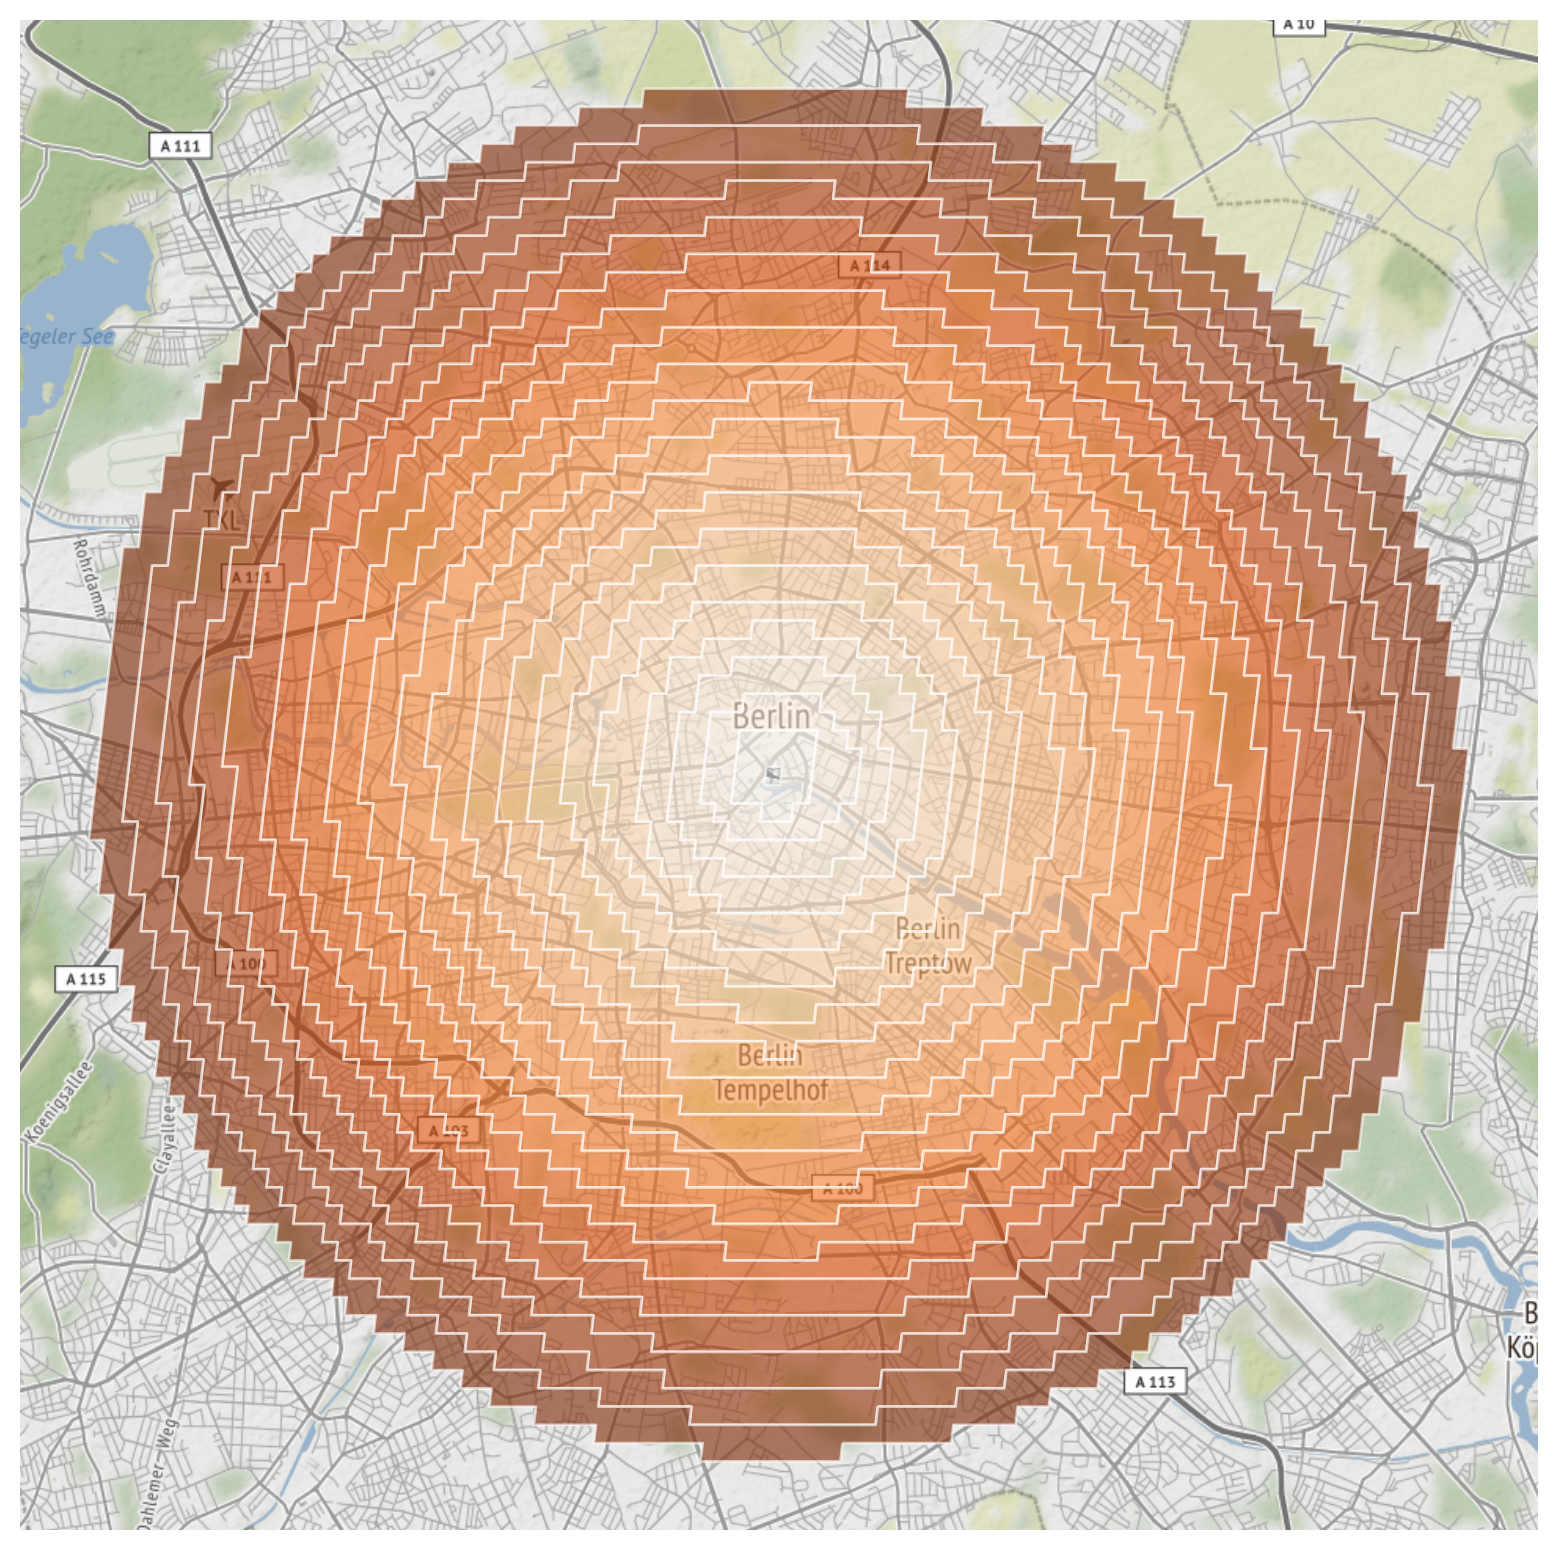

In [62]:
import contextily as ctx
CTX_PROVIDER = ctx.providers.OpenStreetMap.Mapnik

fig, ax = plt.subplots(figsize=(10,10), dpi=200)
gdf_rings = gdf_rings.to_crs(epsg=3857)
gdf_rings.loc['Berlin'].plot(column='car_r_d', ax=ax, alpha=0.6, edgecolor='#fff', cmap='Oranges')
ax.axis('off')
ctx.add_basemap( ax, crs=gdf_rings.crs, source=ctx.providers.Stamen.Terrain, attribution=False)

ax.axis('off')

## City mode detours

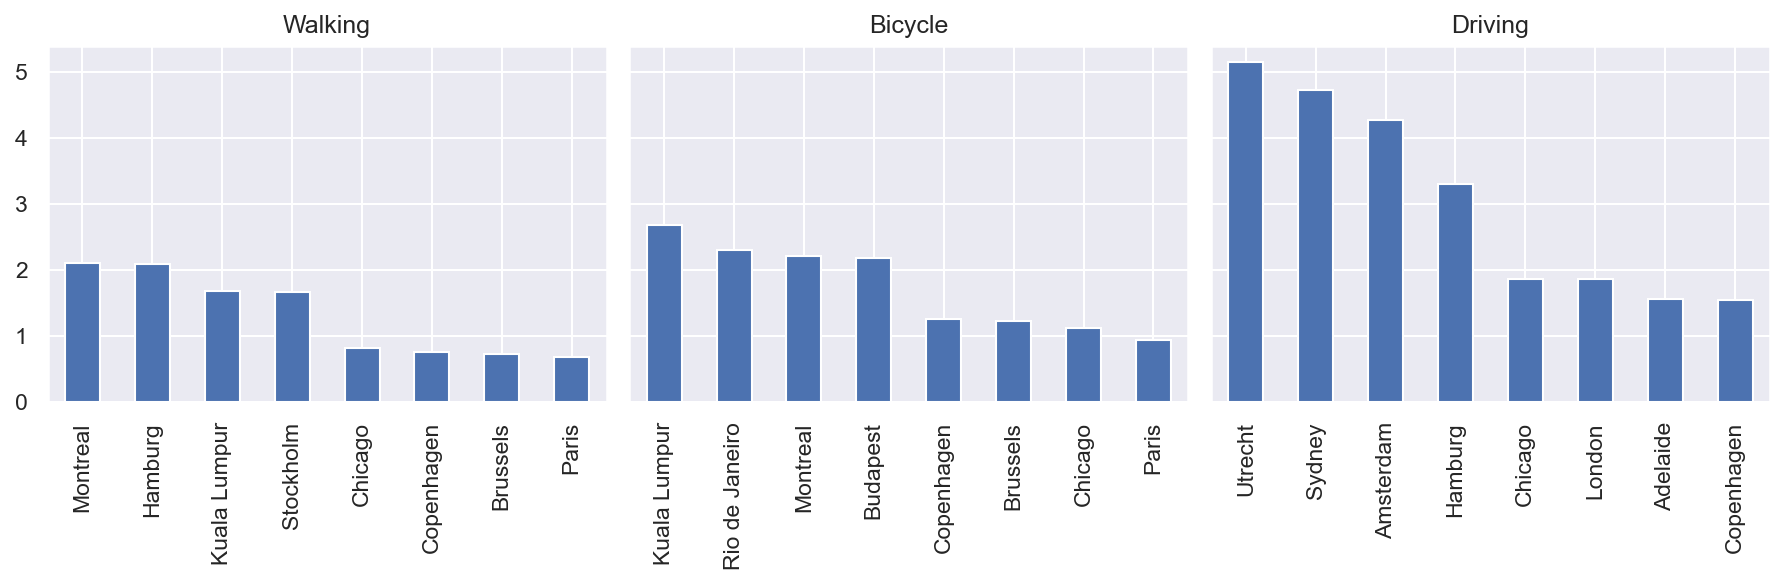

In [26]:
# Generate plots on average above euclidean distances.
rows = [0,1,2,3,-4,-3,-2,-1]

fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharey=True, 
                        dpi=150, tight_layout=True)

axs[0].set_title('Walking')
gdf_detour.walk_deu.sort_values(0, False).iloc[rows].plot(kind='bar', ax=axs[0])
axs[0].set_xlabel('')

axs[1].set_title('Bicycle')
gdf_detour.bike_deu.sort_values(0, False).iloc[rows].plot(kind='bar', ax=axs[1])
axs[1].set_xlabel('')

axs[2].set_title('Driving')
gdf_detour.car_r_deu.sort_values(0, False).iloc[rows].plot(kind='bar', ax=axs[2])
axs[2].set_xlabel('')

fig.savefig(os.path.join(DROOT, '5-graphs', 'above-eucl-distance-sample.png'))

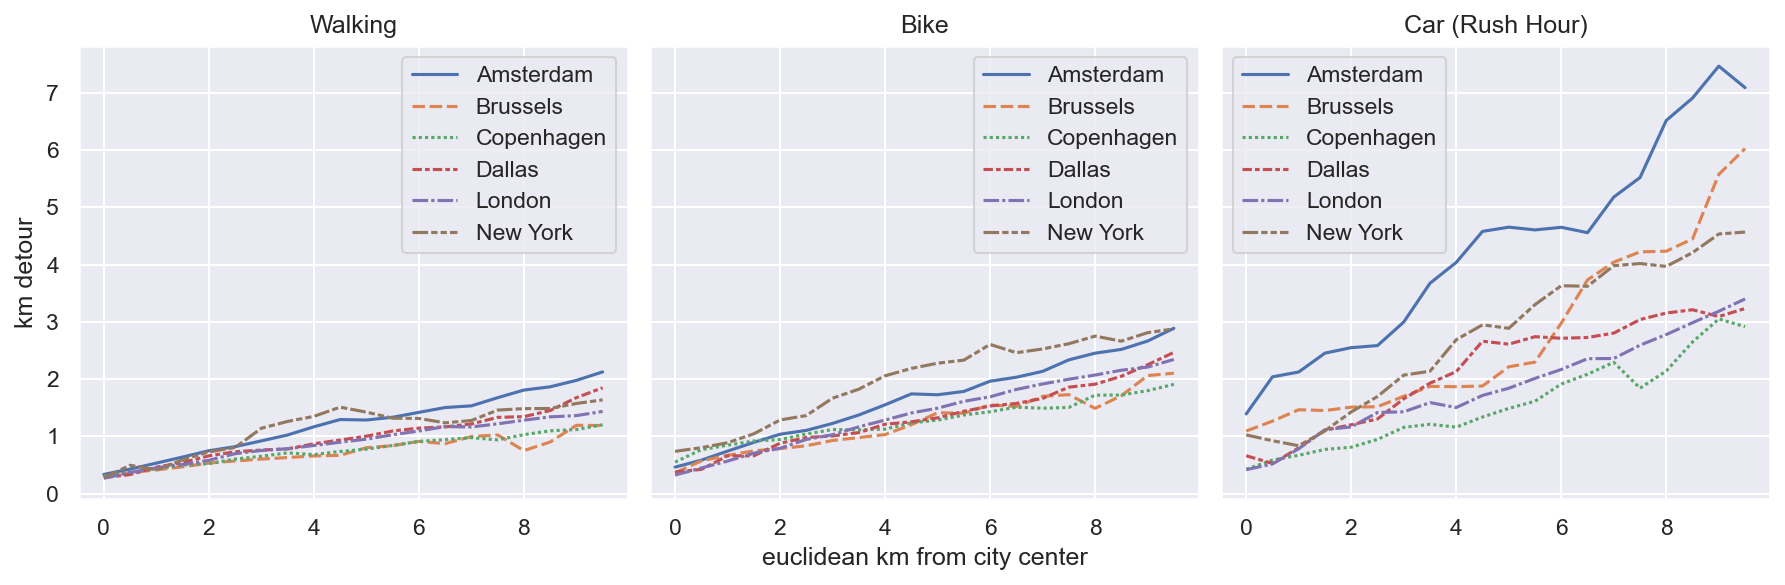

In [27]:
# Map the same as above but for a city selection.
cities = ['Brussels', 'Amsterdam', 'New York', 'Copenhagen', 'Dallas', 'London']
fig, axs = plt.subplots(ncols=3, figsize=(12,4), dpi=150, sharey=True, sharex=True, tight_layout=True)

axs[0].set_title('Walking')
sns.lineplot(data=gdf_rings.loc[cities].walk_deu.unstack(0), ax=axs[0])

axs[1].set_title('Bike')
sns.lineplot(data=gdf_rings.loc[cities].bike_deu.unstack(0), ax=axs[1])

axs[2].set_title('Car (Rush Hour)')
sns.lineplot(data=gdf_rings.loc[cities].car_r_deu.unstack(0), ax=axs[2])

axs[0].set_ylabel('km detour')
axs[0].set_xlabel('')
axs[1].set_xlabel('euclidean km from city center')
axs[2].set_xlabel('')

fig.savefig(os.path.join(DROOT, '5-graphs', 'above-eucl-distance-selection.png'))

## Effective km/h

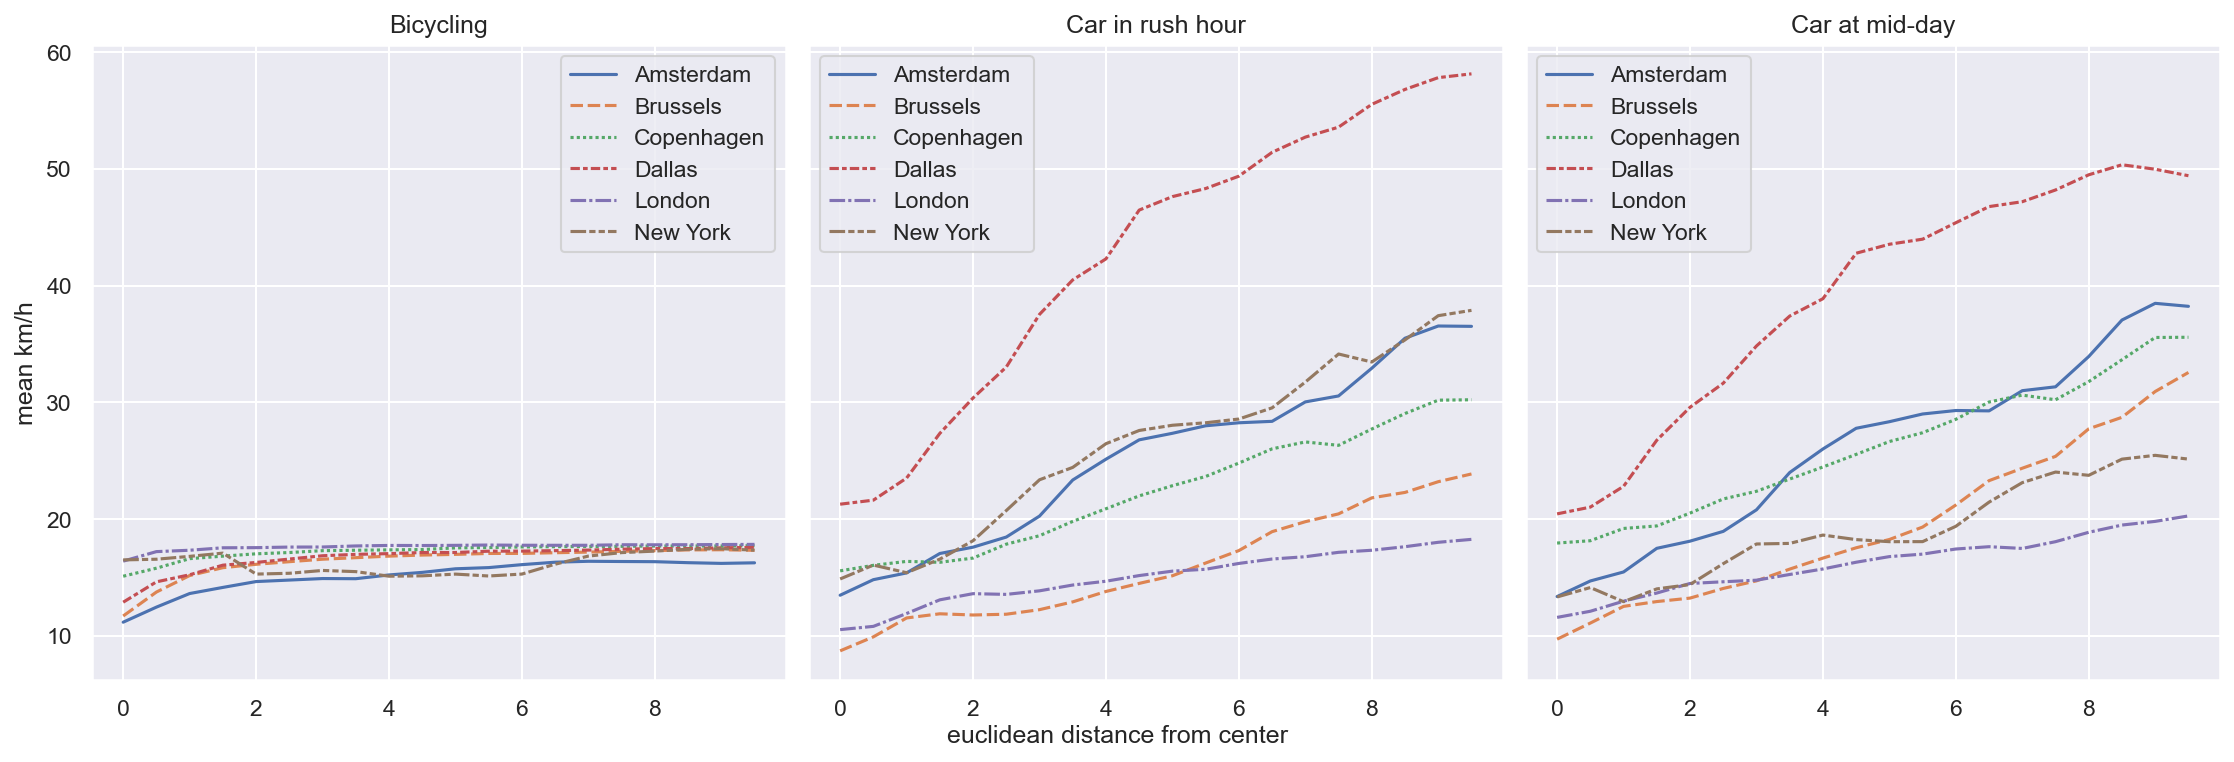

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, tight_layout=True, figsize=(15, 5), dpi=150)

sns.lineplot(data=gdf_rspeeds.loc[cities].bike_s.unstack(0), ax=axs[0])
axs[0].set_title('Bicycling')

axs[1].set_title('Car in rush hour')
sns.lineplot(data=gdf_rspeeds.loc[cities].car_r_s.unstack(0), ax=axs[1])

axs[2].set_title('Car at mid-day')
sns.lineplot(data=gdf_rspeeds.loc[cities].car_m_s.unstack(0), ax=axs[2])

axs[0].set_ylabel('mean km/h')
axs[0].set_xlabel('')
axs[1].set_xlabel('')
axs[2].set_xlabel('')
fig.text(0.5, 0, 'euclidean distance from center', size='large', ha='center')

fig.savefig(os.path.join(DROOT, '5-graphs', 'euclidean-speed.png'))

## Up to where is the bike fastest? (Not very reliable)

In [ ]:
# Plot switchpoint car_r against bikes (300 seconds parking time)
ptime = 300
selection = total_values[ptime].loc['car_r_d'].sort_values()
selection = selection.iloc[[0,1,2,-5,-4-3,-2,-1]]
ax = selection.plot(kind='barh', figsize=(10,10))
ax.legend(labels=['Rush Hour (8:00)'])
ax.set_title(
    'Up to where is bike faster in transport time (%ss parking time)' % ptime)
    
plt.show()